In [3]:
import pandas as pd
from tqdm import tqdm
from database.strategy import Strategy
from database.market import Market
import warnings
warnings.simplefilter(action='ignore', category=Warning)
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import math
import numpy as np
from sklearn.preprocessing import normalize

In [4]:
strat_db = Strategy("unity")
market = Market()

In [5]:
market.connect()
sp5 = market.retrieve_data("sp500")
market.close()

In [6]:
strat_db.connect()
tse = strat_db.retrieve_data("tsmc_epochs")
strat_db.close()

In [7]:
seats = 10
strat_db.connect()
analysis = []
for epoch in tse["epoch"].unique():
    epoch_dict = tse.iloc[epoch]
    trades = strat_db.retrieve_data("tsmc_{}".format(epoch))
    if trades.index.size < 1:
        print(epoch,trades.index.size)
        continue
    else:
        for seat in range(1,seats+1):
            initial = 1000/seats
            seat_trades = trades[trades["seat"] == seat]
            if seat_trades.index.size > 0:
                for delta in seat_trades["sell_delta"]:
                    initial = initial * (1 + delta)
                stg = seat_trades.groupby("seat").mean().reset_index()[["adjclose","sell_price","seat","sell_delta"]]
                stg["epoch"] = epoch
                stg["score"] = epoch_dict["score"]
                stg["ascending"] = epoch_dict["ascending"]
                stg["wdr"] = epoch_dict["wdr"]
                stg["pv"] = initial
                stg["trades"] = seat_trades.index.size
                stg["winrate"] = seat_trades[seat_trades["sell_delta"] > 0].index.size / seat_trades.index.size
                analysis.append(stg)
strat_db.close()

In [8]:
a = pd.concat(analysis)

In [9]:
metric = "pv"

In [10]:
a[a["epoch"] == 3].sort_values(metric,ascending=False)

,adjclose,sell_price,seat,sell_delta,epoch,score,ascending,wdr,pv,trades,winrate
0,53.875075,55.862970,1,0.039895,3,0.7,False,5,1.181309e+07,311,0.842444
0,51.426675,53.269012,3,0.039439,3,0.7,False,5,1.136696e+07,310,0.854839
0,75.754416,79.449644,2,0.036737,3,0.7,False,5,6.844546e+06,320,0.831250
0,96.223312,99.411646,7,0.033471,3,0.7,False,5,2.221964e+06,320,0.781250
0,66.694703,68.760944,5,0.032489,3,0.7,False,5,2.076261e+06,321,0.825545
0,73.297445,75.827243,4,0.032504,3,0.7,False,5,2.050029e+06,321,0.813084
0,89.409082,91.773301,8,0.028878,3,0.7,False,5,6.655458e+05,323,0.811146
0,84.444434,87.246232,6,0.028889,3,0.7,False,5,5.521970e+05,320,0.768750
0,80.437198,82.623652,10,0.029015,3,0.7,False,5,4.377297e+05,307,0.798046
0,85.145295,87.267504,9,0.025367,3,0.7,False,5,2.298439e+05,319,0.793103


In [11]:
apt = a.pivot_table(index=["epoch","score","ascending","wdr"],columns="seat",values=metric)
apt[metric] = [sum([row[1][i] for i in range(1,seats)]) for row in apt.iterrows()]
apt.fillna(0,inplace=True)

In [12]:
apt.sort_values(metric,ascending=False)

,,,seat,1,2,3,4,5,6,7,8,9,10,pv
epoch,score,ascending,wdr,,,,,,,,,,,
3,0.7,False,5,1.181309e+07,6.844546e+06,1.136696e+07,2.050029e+06,2.076261e+06,552196.986734,2.221964e+06,665545.814143,229843.919836,4.377297e+05,3.782043e+07
1,0.7,False,0,1.026033e+07,6.748016e+06,6.543069e+06,2.476535e+06,3.436730e+06,482937.233467,3.230110e+06,670556.975625,349850.454923,1.015492e+06,3.419814e+07
5,0.7,False,10,1.396023e+07,6.154754e+06,3.540792e+06,4.673620e+06,4.889471e+05,808492.012701,3.994470e+05,398454.715080,216513.311809,2.756460e+05,3.064125e+07
4,0.7,True,10,1.748064e+05,2.351988e+05,3.186729e+05,3.888529e+05,1.755439e+05,112299.488327,9.664780e+04,59755.191991,80425.118309,7.302446e+04,1.642203e+06
7,0.8,False,0,2.402322e+05,9.623114e+04,1.294166e+05,1.115423e+05,4.763336e+04,53778.891116,3.019298e+04,40722.895761,62890.493607,4.528411e+04,8.126409e+05
9,0.8,False,5,2.344233e+05,7.166697e+04,5.780755e+04,1.005573e+05,3.505139e+04,32101.361293,4.458746e+04,18029.809588,51212.641854,3.040161e+04,6.454378e+05
2,0.7,True,5,3.473774e+04,6.990120e+04,3.608594e+04,4.928995e+04,8.893431e+04,60570.955471,1.188805e+05,88595.777625,81689.173352,1.209107e+05,6.286856e+05
11,0.8,False,10,1.174265e+05,3.082609e+04,2.502986e+04,3.422836e+04,3.272823e+04,12441.696441,8.849107e+03,11139.953928,9456.568611,7.357009e+03,2.821263e+05
8,0.8,True,5,2.299354e+04,1.305316e+04,2.967757e+04,5.852749e+04,1.292654e+04,63293.807325,1.421520e+04,23479.281379,20721.963494,2.447318e+04,2.588885e+05


In [13]:
strat_db.connect()
epoch = apt.sort_values(metric,ascending=False).reset_index().iloc[0]["epoch"]
analysis = []
trades = strat_db.retrieve_data("tsmc_{}".format(epoch))
strat_db.close()

In [14]:
trades.columns

Index(['_id', 'date', 'ticker', 'adjclose',
       'weekly_price_regression_prediction',
       'weekly_price_regression_prediction_delta',
       'weekly_price_regression_score',
       'trade_signal_classification_prediction',
       'trade_signal_classification_score', 'week', 'year', 'category',
       'predicted_delta', 'sell_price', 'sell_date', 'sell_delta', 'seat'],
      dtype='object')

In [15]:
trades.sort_values("date")
trades["date"] = pd.to_datetime(trades["date"])
trades["sell_date"] = pd.to_datetime(trades["sell_date"])
dta = "date"
trades["week"] = [x.week for x in trades[dta]]
trades["quarter"] = [x.quarter for x in trades[dta]]
trades["dayofWeek"] = [x.weekday() for x in trades[dta]]
trades["month"] = [x.month for x in trades[dta]]
trades["year"] = [x.year for x in trades[dta]]

In [16]:
prices = trades
daily = prices.groupby(["year","dayofWeek"]).mean().reset_index()
quarterly = prices.groupby(["year","quarter"]).mean().reset_index()
monthly = prices.groupby(["year","month"]).mean().reset_index()
weekly = prices.groupby(["year","week"]).mean().reset_index()

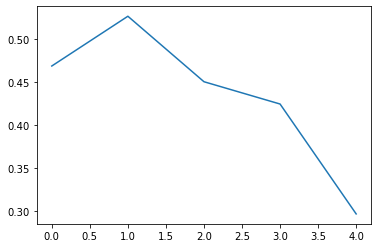

In [17]:
normalized = []
for year in daily["year"].unique():
    subset = daily[daily["year"] == year]
    subset["sell_delta"] = normalize([subset["sell_delta"]])[0]
    normalized.append(subset)
grouped = pd.concat(normalized).groupby("dayofWeek").mean().reset_index()
plt.plot(grouped["sell_delta"])

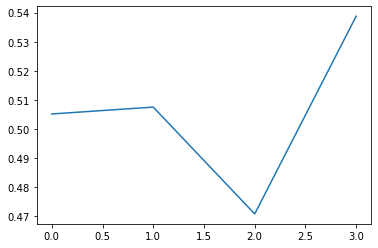

In [18]:
normalized = []
for year in quarterly["year"].unique():
    try:
        subset = quarterly[quarterly["year"] == year]
        subset["sell_delta"] = normalize([subset["sell_delta"]])[0]
        normalized.append(subset)
    except:
        continue
grouped = pd.concat(normalized).groupby("quarter").mean().reset_index()
plt.plot(grouped["sell_delta"])

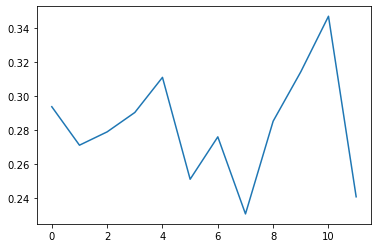

In [19]:
normalized = []
for year in monthly["year"].unique():
    try:
        subset = monthly[monthly["year"] == year]
        subset["sell_delta"] = normalize([subset["sell_delta"]])[0]
        normalized.append(subset)
    except:
        continue
grouped = pd.concat(normalized).groupby("month").mean().reset_index()
plt.plot(grouped["sell_delta"])

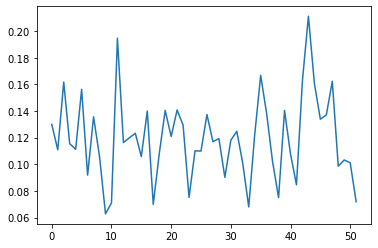

In [20]:
normalized = []
for year in weekly["year"].unique():
    try:
        subset = weekly[weekly["year"] == year]
        subset["sell_delta"] = normalize([subset["sell_delta"]])[0]
        normalized.append(subset)
    except:
        continue
grouped = pd.concat(normalized).groupby("week").mean().reset_index()
plt.plot(grouped["sell_delta"])

In [21]:
ntrades = []
trades.sort_values("date",inplace=True)
for year in trades["year"].unique():
    subset = trades[(trades["year"] == year)]
    for week in subset["week"].unique():
        ntrades.append(len(subset[(subset["week"] == week)]))
weekly["ntrades"]= ntrades

In [22]:
weekly["ntrades"].mean()

22.01736111111111